<a href="https://colab.research.google.com/github/khushimehta1609/tsp-using-gnn/blob/main/TSP_using_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install torch geometric
import os

!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=3588721 sha256=c613b81c8708e7d2476e2b0e03c69abce5022c71104b5e998d9f5aa17f1278e4
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", lin

In [2]:
!pip install torch-geometric

In [3]:
import torch_geometric
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

import numpy as np

import time

from sklearn.utils import shuffle
from scipy.spatial.distance import pdist, squareform
from sklearn.utils.class_weight import compute_class_weight

import matplotlib
import matplotlib.pyplot as plt

import networkx as nx
import torch_geometric

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#@title Dataloader definitions
class DotDict(dict):
    """Wrapper around in-built dict class to access members through the dot operation.
    """

    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self


class GoogleTSPReader(object):
    """Iterator that reads TSP dataset files and yields mini-batches.

    Format expected as in Vinyals et al., 2015: https://arxiv.org/abs/1506.03134, http://goo.gl/NDcOIG
    """

    def __init__(self, num_nodes, num_neighbors, batch_size, filepath):
        """
        Args:
            num_nodes: Number of nodes in TSP tours
            num_neighbors: Number of neighbors to consider for each node in graph
            batch_size: Batch size
            filepath: Path to dataset file (.txt file)
        """
        self.num_nodes = num_nodes
        self.num_neighbors = num_neighbors
        self.batch_size = batch_size
        self.filepath = filepath
        self.filedata = shuffle(open(filepath, "r").readlines())  # Always shuffle upon reading data
        self.max_iter = (len(self.filedata) // batch_size)

    def __iter__(self):
        for batch in range(self.max_iter):
            start_idx = batch * self.batch_size
            end_idx = (batch + 1) * self.batch_size
            yield self.process_batch(self.filedata[start_idx:end_idx])

    def process_batch(self, lines):
        """Helper function to convert raw lines into a mini-batch as a DotDict.
        """
        batch_edges = []
        batch_edges_values = []
        batch_edges_target = []  # Binary classification targets (0/1)
        batch_nodes = []
        batch_nodes_target = []  # Multi-class classification targets (`num_nodes` classes)
        batch_nodes_coord = []
        batch_tour_nodes = []
        batch_tour_len = []

        for line_num, line in enumerate(lines):
            line = line.split(" ")  # Split into list

            # Compute signal on nodes
            nodes = np.ones(self.num_nodes)  # All 1s for TSP...

            # Convert node coordinates to required format
            nodes_coord = []
            for idx in range(0, 2 * self.num_nodes, 2):
                nodes_coord.append([float(line[idx]), float(line[idx + 1])])

            # Compute distance matrix
            W_val = squareform(pdist(nodes_coord, metric='euclidean'))

            # Compute adjacency matrix
            if self.num_neighbors == -1:
                W = np.ones((self.num_nodes, self.num_nodes))  # Graph is fully connected
            else:
                W = np.zeros((self.num_nodes, self.num_nodes))
                # Determine k-nearest neighbors for each node
                knns = np.argpartition(W_val, kth=self.num_neighbors, axis=-1)[:, self.num_neighbors::-1]
                # Make connections
                for idx in range(self.num_nodes):
                    W[idx][knns[idx]] = 1
            np.fill_diagonal(W, 2)  # Special token for self-connections

            # Convert tour nodes to required format
            # Don't add final connection for tour/cycle
            tour_nodes = [int(node) - 1 for node in line[line.index('output') + 1:-1]][:-1]

            # Compute node and edge representation of tour + tour_len
            tour_len = 0
            nodes_target = np.zeros(self.num_nodes)
            edges_target = np.zeros((self.num_nodes, self.num_nodes))
            for idx in range(len(tour_nodes) - 1):
                i = tour_nodes[idx]
                j = tour_nodes[idx + 1]
                nodes_target[i] = idx  # node targets: ordering of nodes in tour
                edges_target[i][j] = 1
                edges_target[j][i] = 1
                tour_len += W_val[i][j]

            # Add final connection of tour in edge target
            nodes_target[j] = len(tour_nodes) - 1
            edges_target[j][tour_nodes[0]] = 1
            edges_target[tour_nodes[0]][j] = 1
            tour_len += W_val[j][tour_nodes[0]]

            # Concatenate the data
            batch_edges.append(W)
            batch_edges_values.append(W_val)
            batch_edges_target.append(edges_target)
            batch_nodes.append(nodes)
            batch_nodes_target.append(nodes_target)
            batch_nodes_coord.append(nodes_coord)
            batch_tour_nodes.append(tour_nodes)
            batch_tour_len.append(tour_len)

        # From list to tensors as a DotDict
        batch = DotDict()
        batch.edges = np.stack(batch_edges, axis=0)
        batch.edges_values = np.stack(batch_edges_values, axis=0)
        batch.edges_target = np.stack(batch_edges_target, axis=0)
        batch.nodes = np.stack(batch_nodes, axis=0)
        batch.nodes_target = np.stack(batch_nodes_target, axis=0)
        batch.nodes_coord = np.stack(batch_nodes_coord, axis=0)
        batch.tour_nodes = np.stack(batch_tour_nodes, axis=0)
        batch.tour_len = np.stack(batch_tour_len, axis=0)
        return batch

dtypeFloat = torch.cuda.FloatTensor
dtypeLong = torch.cuda.LongTensor

In [6]:
num_nodes = 10
num_neighbors = -1    # when set to -1, it considers all the connections instead of k nearest neighbors
train_filepath = f"./drive/MyDrive/tsp_data/tsp{num_nodes}_train_concorde.txt"

dataset = GoogleTSPReader(num_nodes, num_neighbors, 1, train_filepath)

t = time.time()
batch = next(iter(dataset))  # Generate a batch of TSPs
print("Batch generation took: {:.3f} sec".format(time.time() - t))

print("edges:", batch.edges.shape)
print("edges_values:", batch.edges_values.shape)
print("edges_targets:", batch.edges_target.shape)
print("nodes:", batch.nodes.shape)
print("nodes_target:", batch.nodes_target.shape)
print("nodes_coord:", batch.nodes_coord.shape)
print("tour_nodes:", batch.tour_nodes.shape)
print("tour_len:", batch.tour_len.shape)

Batch generation took: 0.001 sec
edges: (1, 10, 10)
edges_values: (1, 10, 10)
edges_targets: (1, 10, 10)
nodes: (1, 10)
nodes_target: (1, 10)
nodes_coord: (1, 10, 2)
tour_nodes: (1, 10)
tour_len: (1,)


In [7]:
#@title Plotting helper function

def plot_tsp(p, x_coord, W, W_val, W_target, title="default"):
    """
    Helper function to plot TSP tours.

    Args:
        p: Matplotlib figure/subplot
        x_coord: Coordinates of nodes
        W: Edge adjacency matrix
        W_val: Edge values (distance) matrix
        W_target: One-hot matrix with 1s on groundtruth/predicted edges
        title: Title of figure/subplot

    Returns:
        p: Updated figure/subplot

    """

    def _edges_to_node_pairs(W):
        """Helper function to convert edge matrix into pairs of adjacent nodes.
        """
        pairs = []
        for r in range(len(W)):
            for c in range(len(W)):
                if W[r][c] == 1:
                    pairs.append((r, c))
        return pairs

    G = nx.DiGraph(W_val)
    pos = dict(zip(range(len(x_coord)), x_coord.tolist()))
    adj_pairs = _edges_to_node_pairs(W)
    target_pairs = _edges_to_node_pairs(W_target)
    colors = ['g'] + ['b'] * (len(x_coord) - 1)  # Green for 0th node, blue for others
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=50)
    nx.draw_networkx_edges(G, pos, edgelist=adj_pairs, alpha=0.3, width=0.5)
    nx.draw_networkx_edges(G, pos, edgelist=target_pairs, alpha=1, width=1, edge_color='r')
    p.set_title(title)
    return p

<Axes: title={'center': 'default'}>

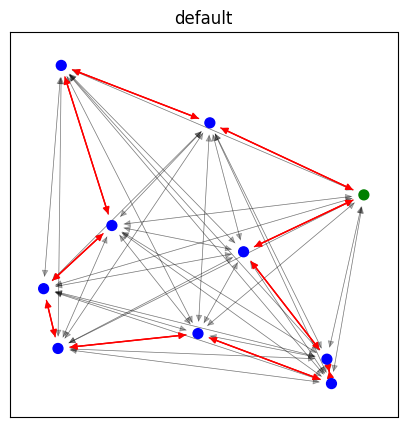

In [8]:
idx = 0
f = plt.figure(figsize=(5, 5))
a = f.add_subplot(111)
plot_tsp(a, batch.nodes_coord[idx], batch.edges[idx], batch.edges_values[idx], batch.edges_target[idx])

In [9]:
#@title Batch normalization layers
class BatchNormNode(nn.Module):
    """Batch normalization for node features.
    """

    def __init__(self, hidden_dim):
        super(BatchNormNode, self).__init__()
        self.batch_norm = nn.BatchNorm1d(hidden_dim, track_running_stats=False)

    def forward(self, x):
        """
        Args:
            x: Node features (batch_size, num_nodes, hidden_dim)

        Returns:
            x_bn: Node features after batch normalization (batch_size, num_nodes, hidden_dim)
        """
        x_trans = x.transpose(1, 2).contiguous()  # Reshape input: (batch_size, hidden_dim, num_nodes)
        x_trans_bn = self.batch_norm(x_trans)
        x_bn = x_trans_bn.transpose(1, 2).contiguous()  # Reshape to original shape
        return x_bn


class BatchNormEdge(nn.Module):
    """Batch normalization for edge features.
    """

    def __init__(self, hidden_dim):
        super(BatchNormEdge, self).__init__()
        self.batch_norm = nn.BatchNorm2d(hidden_dim, track_running_stats=False)

    def forward(self, e):
        """
        Args:
            e: Edge features (batch_size, num_nodes, num_nodes, hidden_dim)

        Returns:
            e_bn: Edge features after batch normalization (batch_size, num_nodes, num_nodes, hidden_dim)
        """
        e_trans = e.transpose(1, 3).contiguous()  # Reshape input: (batch_size, num_nodes, num_nodes, hidden_dim)
        e_trans_bn = self.batch_norm(e_trans)
        e_bn = e_trans_bn.transpose(1, 3).contiguous()  # Reshape to original
        return e_bn

In [10]:
#@title MLP layer
class MLP(nn.Module):
    """Multi-layer Perceptron for output prediction.
    """

    def __init__(self, hidden_dim, output_dim, L=2):
        super(MLP, self).__init__()
        self.L = L
        U = []
        for layer in range(self.L - 1):
            U.append(nn.Linear(hidden_dim, hidden_dim, True))
        self.U = nn.ModuleList(U)
        self.V = nn.Linear(hidden_dim, output_dim, True)

    def forward(self, x):
        """
        Args:
            x: Input features (batch_size, hidden_dim)

        Returns:
            y: Output predictions (batch_size, output_dim)
        """
        Ux = x
        for U_i in self.U:
            Ux = U_i(Ux)  # B x H
            Ux = F.relu(Ux)  # B x H
        y = self.V(Ux)  # B x O
        return y

In [11]:
class NodeFeatures(nn.Module):
    """Convnet features for nodes.

    Using `sum` aggregation:
        x_i = U*x_i +  sum_j [ gate_ij * (V*x_j) ]

    Using `mean` aggregation:
        x_i = U*x_i + ( sum_j [ gate_ij * (V*x_j) ] / sum_j [ gate_ij] )
    """

    def __init__(self, hidden_dim, aggregation="mean"):
        super(NodeFeatures, self).__init__()
        self.aggregation = aggregation
        self.U = nn.Linear(hidden_dim, hidden_dim, True)
        self.V = nn.Linear(hidden_dim, hidden_dim, True)

    def forward(self, x, edge_gate):
        """
        Args:
            x: Node features (batch_size, num_nodes, hidden_dim)
            edge_gate: Edge gate values (batch_size, num_nodes, num_nodes, hidden_dim)

        Returns:
            x_new: Convolved node features (batch_size, num_nodes, hidden_dim)
        """
        Ux = self.U(x)  # B x V x H
        Vx = self.V(x)  # B x V x H
        Vx = Vx.unsqueeze(1)  # extend Vx from "B x V x H" to "B x 1 x V x H"
        gateVx = edge_gate * Vx  # B x V x V x H
        if self.aggregation=="mean":
            x_new = Ux + torch.sum(gateVx, dim=2) / (1e-20 + torch.sum(edge_gate, dim=2))  # B x V x H
        elif self.aggregation=="sum":
            x_new = Ux + torch.sum(gateVx, dim=2)  # B x V x H
        return x_new


class EdgeFeatures(nn.Module):
    """Convnet features for edges.

    e_ij = U*e_ij + V*(x_i + x_j)
    """

    def __init__(self, hidden_dim):
        super(EdgeFeatures, self).__init__()
        self.U = nn.Linear(hidden_dim, hidden_dim, True)
        self.V = nn.Linear(hidden_dim, hidden_dim, True)

    def forward(self, x, e):
        """
        Args:
            x: Node features (batch_size, num_nodes, hidden_dim)
            e: Edge features (batch_size, num_nodes, num_nodes, hidden_dim)

        Returns:
            e_new: Convolved edge features (batch_size, num_nodes, num_nodes, hidden_dim)
        """
        Ue = self.U(e)
        Vx = self.V(x)
        Wx = Vx.unsqueeze(1)  # Extend Vx from "B x V x H" to "B x V x 1 x H"
        Vx = Vx.unsqueeze(2)  # extend Vx from "B x V x H" to "B x 1 x V x H"
        e_new = Ue + Vx + Wx
        return e_new

In [12]:
class ResidualGatedGCNLayer(nn.Module):
    """Convnet layer with gating and residual connection.
    """

    def __init__(self, hidden_dim, aggregation="sum"):
        super(ResidualGatedGCNLayer, self).__init__()
        self.node_feat = NodeFeatures(hidden_dim, aggregation)
        self.edge_feat = EdgeFeatures(hidden_dim)
        self.bn_node = BatchNormNode(hidden_dim)
        self.bn_edge = BatchNormEdge(hidden_dim)

    def forward(self, x, e):
        """
        Args:
            x: Node features (batch_size, num_nodes, hidden_dim)
            e: Edge features (batch_size, num_nodes, num_nodes, hidden_dim)

        Returns:
            x_new: Convolved node features (batch_size, num_nodes, hidden_dim)
            e_new: Convolved edge features (batch_size, num_nodes, num_nodes, hidden_dim)
        """
        e_in = e
        x_in = x
        # Edge convolution
        e_tmp = self.edge_feat(x_in, e_in)  # B x V x V x H
        # Compute edge gates
        edge_gate = torch.sigmoid(e_tmp)
        # Node convolution
        x_tmp = self.node_feat(x_in, edge_gate)
        # Batch normalization
        e_tmp = self.bn_edge(e_tmp)
        x_tmp = self.bn_node(x_tmp)
        # ReLU Activation
        e = F.relu(e_tmp)
        x = F.relu(x_tmp)
        # Residual connection
        x_new = x_in + x
        e_new = e_in + e
        return x_new, e_new

In [13]:
from torch_geometric.nn import TransformerConv


class ResidualGatedGCNModel(nn.Module):
    """Residual Gated GCN Model for outputting predictions as edge adjacency matrices.
    """

    def __init__(self, config, dtypeFloat, dtypeLong):
        super(ResidualGatedGCNModel, self).__init__()
        self.dtypeFloat = dtypeFloat
        self.dtypeLong = dtypeLong
        # Define net parameters
        self.num_nodes = config['num_nodes']
        self.node_dim = config['node_dim']
        self.voc_nodes_in = config['voc_nodes_in']
        self.voc_nodes_out = config['num_nodes']
        self.voc_edges_in = config['voc_edges_in']
        self.voc_edges_out = config['voc_edges_out']
        self.hidden_dim = config['hidden_dim']
        self.num_layers = config['num_layers']
        self.mlp_layers = config['mlp_layers']
        self.aggregation = config['aggregation']
        # Node and edge embedding layers/lookups

        # We are using TransformerConv layer from torch geometric library!
        self.nodes_coord_embedding = TransformerConv(self.node_dim, self.hidden_dim)

        self.edges_values_embedding = nn.Linear(1, self.hidden_dim//2, bias=False)
        self.edges_embedding = nn.Embedding(self.voc_edges_in, self.hidden_dim//2)
        # Define GCN Layers
        gcn_layers = []
        for layer in range(self.num_layers):
            gcn_layers.append(ResidualGatedGCNLayer(self.hidden_dim, self.aggregation))
        self.gcn_layers = nn.ModuleList(gcn_layers)
        # Define MLP classifiers
        self.mlp_edges = MLP(self.hidden_dim, self.voc_edges_out, self.mlp_layers)

    def loss_edges(self, y_pred_edges, y_edges, edge_cw):
        """
        Loss function for edge predictions.

        Args:
            y_pred_edges: Predictions for edges (batch_size, num_nodes, num_nodes)
            y_edges: Targets for edges (batch_size, num_nodes, num_nodes)
            edge_cw: Class weights for edges loss

        Returns:
            loss_edges: Value of loss function

        """
        # Edge loss
        y = F.log_softmax(y_pred_edges, dim=3)  # B x V x V x voc_edges
        y = y.permute(0, 3, 1, 2)  # B x voc_edges x V x V
        loss_edges = nn.NLLLoss(edge_cw)
        loss = loss_edges(y.contiguous(), y_edges)
        return loss

    def forward(self, x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw):
        """
        Args:
            x_edges: Input edge adjacency matrix (batch_size, num_nodes, num_nodes)
            x_edges_values: Input edge distance matrix (batch_size, num_nodes, num_nodes)
            x_nodes: Input nodes (batch_size, num_nodes)
            x_nodes_coord: Input node coordinates (batch_size, num_nodes, node_dim)
            y_edges: Targets for edges (batch_size, num_nodes, num_nodes)
            edge_cw: Class weights for edges loss
            # y_nodes: Targets for nodes (batch_size, num_nodes, num_nodes)
            # node_cw: Class weights for nodes loss

        Returns:
            y_pred_edges: Predictions for edges (batch_size, num_nodes, num_nodes)
            # y_pred_nodes: Predictions for nodes (batch_size, num_nodes)
            loss: Value of loss function
        """
        # Node and edge embedding
        edge_index = torch.squeeze(x_edges).nonzero().t().contiguous()
        x = self.nodes_coord_embedding(torch.squeeze(x_nodes_coord), edge_index)
        x = torch.unsqueeze(x, 0)
        e_vals = self.edges_values_embedding(x_edges_values.unsqueeze(3))  # B x V x V x H
        e_tags = self.edges_embedding(x_edges)  # B x V x V x H
        e = torch.cat((e_vals, e_tags), dim=3)
        # GCN layers
        for layer in range(self.num_layers):
            x, e = self.gcn_layers[layer](x, e)  # B x V x H, B x V x V x H
        # MLP classifier
        y_pred_edges = self.mlp_edges(e)  # B x V x V x voc_edges_out

        # Compute loss
        edge_cw = torch.Tensor(edge_cw).type(self.dtypeFloat)  # Convert to tensors
        loss = self.loss_edges(y_pred_edges.cuda(), y_edges.cuda(), edge_cw)

        return y_pred_edges, loss

In [14]:
#@title Hyperparameters
from torch_geometric.nn import TransformerConv
import torch
import torch.nn as nn

num_nodes = 10 #@param # Could also be 10, 20, or 30!
num_neighbors = -1 # Could increase it!
train_filepath = f"./drive/MyDrive/tsp_data/tsp{10}_train_concorde.txt"
hidden_dim = 300 #@param
num_layers = 5 #@param
mlp_layers = 2 #@param
learning_rate = 0.001 #@param
max_epochs = 30 #@param
batches_per_epoch = 10000

variables = {'train_filepath': f'./drive/MyDrive/tsp_data/tsp{num_nodes}_train_concorde.txt',
             'val_filepath': f'./drive/MyDrive/tsp_data/tsp{num_nodes}_val_concorde.txt',
             'test_filepath': f'./drive/MyDrive/tsp_data/tsp{num_nodes}_test_concorde.txt',
             'num_nodes': 10,
             'num_neighbors': num_neighbors,
             'node_dim': 2 ,
             'voc_nodes_in': 2,
             'voc_nodes_out': 2,
             'voc_edges_in': 3,
             'voc_edges_out': 2,
             'hidden_dim': 300,
             'num_layers': 5,
             'mlp_layers': 2,
             'aggregation': 'mean',
             'max_epochs': 30,
             'val_every': 5,
             'test_every': 5,
             'batches_per_epoch': 1000,
             'accumulation_steps': 1,
             'learning_rate': 0.001,
             'decay_rate': 1.01
             }
net = nn.DataParallel(ResidualGatedGCNModel(variables, torch.cuda.FloatTensor, torch.cuda.LongTensor))
net.cuda()

# Compute number of network parameters
nb_param = 0
for param in net.parameters():
    nb_param += np.prod(list(param.data.size()))
print('Number of parameters:', nb_param)

Number of parameters: 1907102


In [15]:
def train_one_epoch(net, optimizer, config):
    # Set training mode
    net.train()

    # Assign parameters
    num_nodes = config['num_nodes']
    num_neighbors = config['num_neighbors']
    batches_per_epoch = config['batches_per_epoch']
    accumulation_steps = config['accumulation_steps']
    train_filepath = config['train_filepath']

    # Load TSP data
    dataset = GoogleTSPReader(num_nodes, num_neighbors, 1, train_filepath)
    if batches_per_epoch != -1:
        batches_per_epoch = min(batches_per_epoch, dataset.max_iter)
    else:
        batches_per_epoch = dataset.max_iter

    # Convert dataset to iterable
    dataset = iter(dataset)

    # Initially set loss class weights as None
    edge_cw = None

    # Initialize running data
    running_loss = 0.0
    running_nb_data = 0

    start_epoch = time.time()
    for batch_num in range(batches_per_epoch):
        # Generate a batch of TSPs
        try:
            batch = next(dataset)
        except StopIteration:
            break

        # Convert batch to torch Variables
        x_edges = Variable(torch.cuda.LongTensor(batch.edges).type(dtypeLong), requires_grad=False)
        x_edges_values = Variable(torch.cuda.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
        x_nodes = Variable(torch.cuda.LongTensor(batch.nodes).type(dtypeLong), requires_grad=False)
        x_nodes_coord = Variable(torch.cuda.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
        y_edges = Variable(torch.cuda.LongTensor(batch.edges_target).type(dtypeLong), requires_grad=False)
        y_nodes = Variable(torch.cuda.LongTensor(batch.nodes_target).type(dtypeLong), requires_grad=False)

        # Compute class weights (if uncomputed)
        if type(edge_cw) != torch.Tensor:
            edge_labels = y_edges.cpu().numpy().flatten()
            edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)

        # Forward pass
        y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw)
        loss = loss.mean()  # Take mean of loss across multiple GPUs
        loss = loss / accumulation_steps  # Scale loss by accumulation steps
        loss.backward()

        # Backward pass
        if (batch_num+1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # Update running data
        running_nb_data += 1
        running_loss += loss.data.item()* accumulation_steps  # Re-scale loss

    # Compute statistics for full epoch
    loss = running_loss/ running_nb_data

    return time.time()-start_epoch, loss

In [16]:
def test(net, config, mode='test'):
    # Set evaluation mode
    net.eval()

    # Assign parameters
    num_nodes = config['num_nodes']
    num_neighbors = config['num_neighbors']
    batches_per_epoch = 1 # config['batches_per_epoch']
    val_filepath = config['val_filepath']
    test_filepath = config['test_filepath']

    # Load TSP data
    if mode == 'val':
        dataset = GoogleTSPReader(num_nodes, num_neighbors, 1, filepath=val_filepath)
    elif mode == 'test':
        dataset = GoogleTSPReader(num_nodes, num_neighbors, 1, filepath=test_filepath)

    # Convert dataset to iterable
    dataset = iter(dataset)

    # Initially set loss class weights as None
    edge_cw = None

    # Initialize running data
    running_loss = 0.0
    running_nb_data = 0

    with torch.no_grad():
        start_test = time.time()
        for batch_num in range(batches_per_epoch):
            # Generate a batch of TSPs
            try:
                batch = next(dataset)
            except StopIteration:
                break

            # Convert batch to torch Variables
            x_edges = Variable(torch.cuda.LongTensor(batch.edges).type(dtypeLong), requires_grad=False)
            x_edges_values = Variable(torch.cuda.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
            x_nodes = Variable(torch.cuda.LongTensor(batch.nodes).type(dtypeLong), requires_grad=False)
            x_nodes_coord = Variable(torch.cuda.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
            y_edges = Variable(torch.cuda.LongTensor(batch.edges_target).type(dtypeLong), requires_grad=False)
            y_nodes = Variable(torch.cuda.LongTensor(batch.nodes_target).type(dtypeLong), requires_grad=False)

            # Compute class weights (if uncomputed)
            if type(edge_cw) != torch.Tensor:
                edge_labels = y_edges.cpu().numpy().flatten()
                edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)

            # Forward pass
            y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw)
            loss = loss.mean()  # Take mean of loss across multiple GPUs

            # Update running data
            running_nb_data += 1
            running_loss += loss.data.item()

    # Compute statistics for full epoch
    loss = running_loss/ running_nb_data

    return time.time()-start_test, loss

def update_learning_rate(optimizer, lr):
  """
  Updates learning rate for given optimizer.

  Args:
      optimizer: Optimizer object
      lr: New learning rate

  Returns:
      optimizer: Updated optimizer objects
  """
  for param_group in optimizer.param_groups:
      param_group['lr'] = lr
  return optimizer

In [17]:
# Define optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=variables["learning_rate"])
val_loss_old = None

train_losses = []
val_losses = []
test_losses = []

for epoch in range(variables["max_epochs"]):
    # Train
    train_time, train_loss = train_one_epoch(net, optimizer, variables)
    # Print metrics
    train_losses.append(train_loss)
    print(f"Epoch: {epoch}, Train Loss: {train_loss}")

    if epoch % variables["val_every"] == 0 or epoch == variables["max_epochs"]-1:
        # Validate
        val_time, val_loss = test(net, variables, mode='val')
        val_losses.append(val_loss)
        print(f"Epoch: {epoch}, Val Loss; {val_loss}")

        # Update learning rate
        if val_loss_old != None and val_loss > 0.99 * val_loss_old:
            variables["learning_rate"] /= variables["decay_rate"]
            optimizer = update_learning_rate(optimizer, variables["learning_rate"])

        val_loss_old = val_loss  # Update old validation loss

    if epoch % variables["test_every"] == 0 or epoch == variables["max_epochs"]-1:
        # Test
        test_time, test_loss = test(net, variables, mode='test')
        test_losses.append(test_loss)
        print(f"Epoch: {epoch}, Test Loss; {test_loss}\n")

<ipython-input-15-0df351b48cac>:38: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  x_edges = Variable(torch.cuda.LongTensor(batch.edges).type(dtypeLong), requires_grad=False)


Epoch: 0, Train Loss: 0.260636901281774
Epoch: 0, Val Loss; 0.21816416084766388
Epoch: 0, Test Loss; 0.18665418028831482

Epoch: 1, Train Loss: 0.20266376124322413
Epoch: 2, Train Loss: 0.1821471392735839
Epoch: 3, Train Loss: 0.17480013428442182
Epoch: 4, Train Loss: 0.16233011597767472
Epoch: 5, Train Loss: 0.15949401038885117
Epoch: 5, Val Loss; 0.3197435140609741
Epoch: 5, Test Loss; 0.08641324192285538

Epoch: 6, Train Loss: 0.15477923880517483
Epoch: 7, Train Loss: 0.15336059710849076
Epoch: 8, Train Loss: 0.15466516277939082
Epoch: 9, Train Loss: 0.15019057387579232
Epoch: 10, Train Loss: 0.1493273108773865
Epoch: 10, Val Loss; 0.25722000002861023
Epoch: 10, Test Loss; 0.12466567754745483

Epoch: 11, Train Loss: 0.14137624485045672
Epoch: 12, Train Loss: 0.13825950071681292
Epoch: 13, Train Loss: 0.1355298966136761
Epoch: 14, Train Loss: 0.12943621652433648
Epoch: 15, Train Loss: 0.13198822574689983
Epoch: 15, Val Loss; 0.3151959776878357
Epoch: 15, Test Loss; 0.0292381625622510

In [18]:
#@title Plotting helper functions

def plot_loss_curve(train_loss, val_loss, test_loss, config):
    # Create a figure and axis object
    fig, ax = plt.subplots()

    # Plot the losses on the axis
    val_every = config["val_every"]
    test_every = config["test_every"]
    test_every = [15]
    ax.plot(train_loss, color='green', label='Train Loss')
    ax.plot([i * val_every for i in range(len(val_loss))], val_loss, color='orange', label='Val Loss')
    ax.plot([i * test_every for i in range(len(test_loss))], test_loss, color='purple', label='Test Loss')

    # Add axis labels and title
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title("Loss Curve")
    ax.legend()

    # Show the plot
    plt.figure(figsize=(15,10))
    plt.show()

def plot_tsp_heatmap(p, x_coord, W_val, W_pred, title="default"):
    """
    Helper function to plot predicted TSP tours with edge strength denoting confidence of prediction.

    Args:
        p: Matplotlib figure/subplot
        x_coord: Coordinates of nodes
        W_val: Edge values (distance) matrix
        W_pred: Edge predictions matrix
        title: Title of figure/subplot

    Returns:
        p: Updated figure/subplot

    """

    def _edges_to_node_pairs(W):
        """Helper function to convert edge matrix into pairs of adjacent nodes.
        """
        pairs = []
        edge_preds = []
        for r in range(len(W)):
            for c in range(len(W)):
                if W[r][c] > 0.25:
                    pairs.append((r, c))
                    edge_preds.append(W[r][c])
        return pairs, edge_preds

    G = nx.Graph(W_val)
    pos = dict(zip(range(len(x_coord)), x_coord.tolist()))
    node_pairs, edge_color = _edges_to_node_pairs(W_pred)
    node_color = ['g'] + ['b'] * (len(x_coord) - 1)  # Green for 0th node, blue for others
    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=50)
    nx.draw_networkx_edges(G, pos, edgelist=node_pairs, edge_color=edge_color, edge_cmap=plt.cm.Reds, width=0.75)
    p.set_title(title)
    return p


def plot_predictions(x_nodes_coord, x_edges, x_edges_values, y_edges, y_pred_edges, num_plots=3):
    """
    Plots groundtruth TSP tour vs. predicted tours (with beamsearch).

    Args:
        x_nodes_coord: Input node coordinates (batch_size, num_nodes, node_dim)
        x_edges: Input edge adjacency matrix (batch_size, num_nodes, num_nodes)
        x_edges_values: Input edge distance matrix (batch_size, num_nodes, num_nodes)
        y_edges: Groundtruth labels for edges (batch_size, num_nodes, num_nodes)
        y_pred_edges: Predictions for edges (batch_size, num_nodes, num_nodes)
        num_plots: Number of figures to plot

    """
    y = F.softmax(y_pred_edges, dim=3)  # B x V x V x voc_edges
    y_bins = y.argmax(dim=3)  # Binary predictions: B x V x V
    y_probs = y[:,:,:,1]  # Prediction probabilities: B x V x V
    for f_idx, idx in enumerate(np.random.choice(len(y), num_plots, replace=False)):
        f = plt.figure(f_idx, figsize=(15, 5))
        x_coord = x_nodes_coord[idx].cpu().numpy()
        W = x_edges[idx].cpu().numpy()
        W_val = x_edges_values[idx].cpu().numpy()
        W_target = y_edges[idx].cpu().numpy()
        W_sol_bins = y_bins[idx].cpu().numpy()
        W_sol_probs = y_probs[idx].cpu().numpy()
        plt1 = f.add_subplot(131)
        plot_tsp(plt1, x_coord.squeeze(), W.squeeze(), W_val.squeeze(), W_target.squeeze(), 'Groundtruth')
        plt2 = f.add_subplot(132)
        plot_tsp_heatmap(plt2, x_coord.squeeze(), W_val.squeeze(), W_sol_probs.squeeze(), 'Prediction Heatmap')
        plt.show()

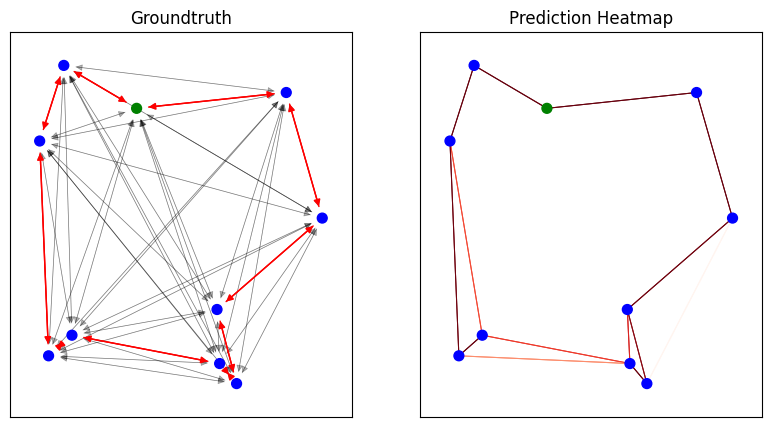

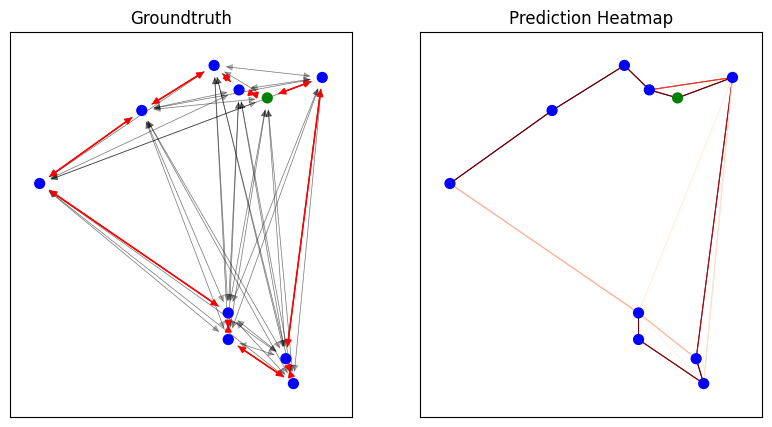

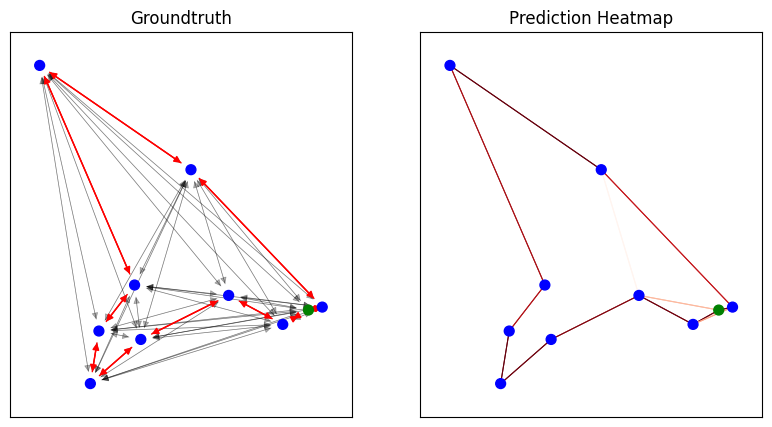

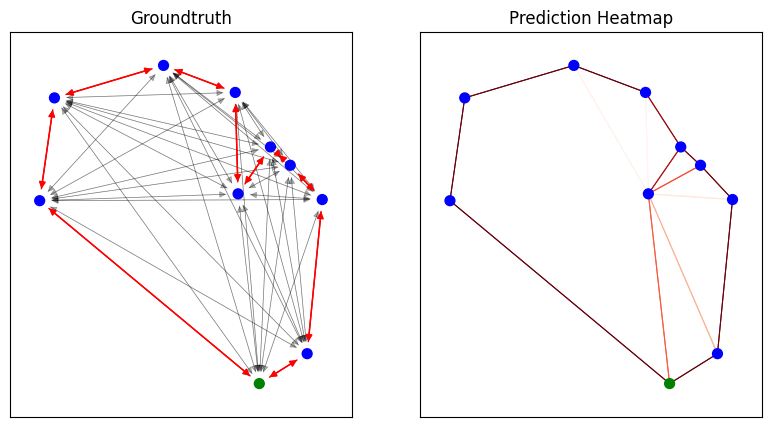

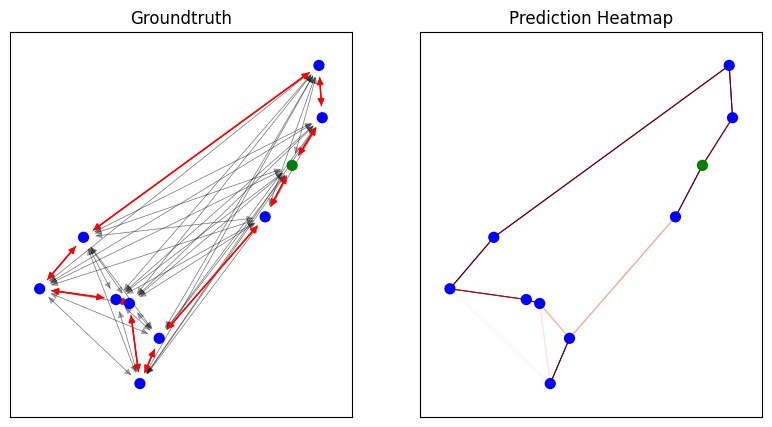

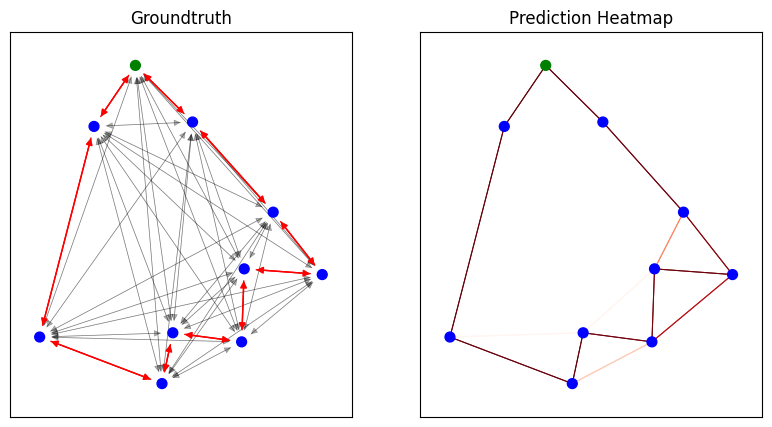

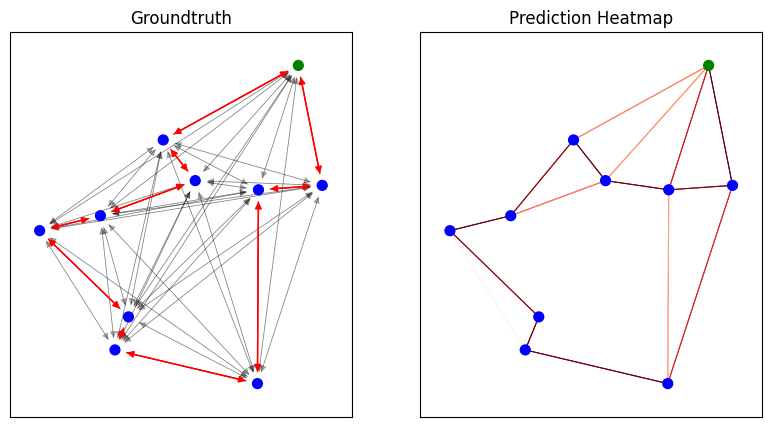

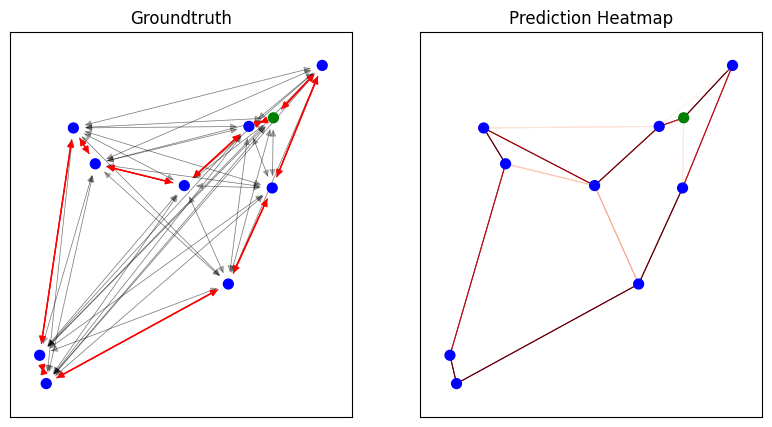

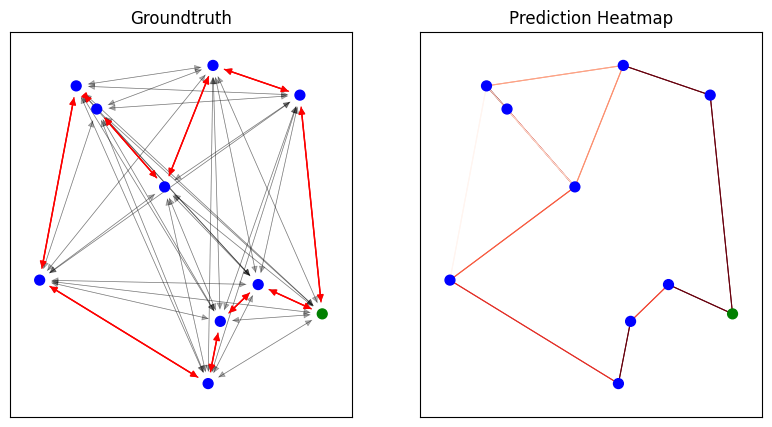

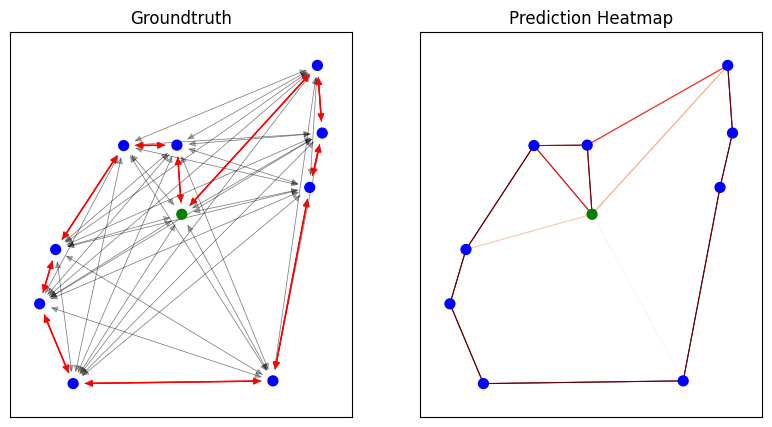

In [22]:
# Set evaluation mode
net.eval()

num_samples = 10
num_nodes = variables['num_nodes']
num_neighbors = variables['num_neighbors']
test_filepath = variables['test_filepath']
dataset = iter(GoogleTSPReader(num_nodes, num_neighbors, 1, test_filepath))


x_edges = []
x_edges_values = []
x_nodes = []
x_nodes_coord = []
y_edges = []
y_nodes = []
y_preds = []

with torch.no_grad():
    for i in range(num_samples):
        sample = next(dataset)
        # Convert batch to torch Variables
        x_edges.append(Variable(torch.LongTensor(sample.edges).type(dtypeLong), requires_grad=False))
        x_edges_values.append(Variable(torch.FloatTensor(sample.edges_values).type(dtypeFloat), requires_grad=False))
        x_nodes.append(Variable(torch.LongTensor(sample.nodes).type(dtypeLong), requires_grad=False))
        x_nodes_coord.append(Variable(torch.FloatTensor(sample.nodes_coord).type(dtypeFloat), requires_grad=False))
        y_edges.append(Variable(torch.LongTensor(sample.edges_target).type(dtypeLong), requires_grad=False))
        y_nodes.append(Variable(torch.LongTensor(sample.nodes_target).type(dtypeLong), requires_grad=False))

        # Compute class weights
        edge_labels = (y_edges[-1].cpu().numpy().flatten())
        edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)

        # Forward pass
        y_pred, loss = net.forward(x_edges[-1], x_edges_values[-1], x_nodes[-1], x_nodes_coord[-1], y_edges[-1], edge_cw)
        y_preds.append(y_pred)


y_preds = torch.squeeze(torch.stack(y_preds))
# Plot prediction visualizations
plot_predictions(x_nodes_coord, x_edges, x_edges_values, y_edges, y_preds, num_plots=num_samples)